In [20]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine  
import os
from dotenv import load_dotenv

In [21]:
# Load data from the .env file

load_dotenv()

snowflake_user = os.getenv("SNOWFLAKE_USER")
snowflake_password = os.getenv("SNOWFLAKE_PASSWORD")
snowflake_account = os.getenv("SNOWFLAKE_ACCOUNT")
snowflake_database = os.getenv("SNOWFLAKE_DATABASE")
snowflake_schema = os.getenv("SNOWFLAKE_SCHEMA")
snowflake_warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")

Snowflake_connect = f"snowflake://{snowflake_user}:{snowflake_password}@{snowflake_account}/{snowflake_database}/{snowflake_schema}?warehouse={snowflake_warehouse}"


# database connection to Snowflake
e = create_engine(Snowflake_connect) 


## 1. Top 10 games by millions of copies sold

In [22]:
# Select all information for the top ten best-selling games and order the results from best-selling game down to tenth best-selling.

query=''' 
SELECT * 
FROM game_sales 
ORDER BY games_sold DESC 
LIMIT 10;
'''

# Select all information for the top ten best-selling games and order the results from best-selling game down to tenth best-selling. Then, order those results by year from recent to oldest.

query2='''
SELECT *
FROM (
    SELECT * 
    FROM game_sales 
    ORDER BY games_sold DESC 
    LIMIT 10
)
ORDER BY year DESC;
'''

display(pd.read_sql(query2, con=e))


,rank,game,platform,publisher,developer,games_sold,year
0,5,PLAYERUNKNOWN'S BATTLEGROUNDS,PC,PUBG Corporation,PUBG Corporation,37,2017
1,3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,40,2012
2,6,Minecraft,PC,Mojang,Mojang AB,33,2010
3,7,Wii Sports Resort,Wii,Nintendo,Nintendo EAD,33,2009
4,10,New Super Mario Bros. Wii,Wii,Nintendo,Nintendo EAD,30,2009
5,4,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,37,2008
6,1,Wii Sports,Wii,Nintendo,Nintendo EAD,83,2006
7,9,New Super Mario Bros.,DS,Nintendo,Nintendo EAD,31,2006
8,8,Pokemon Red / Green / Blue Version,GB,Nintendo,Game Freak,31,1998
9,2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,40,1985


## 2. Missing review scores
<p>Wow, the best-selling video games were released between 1985 to 2017! That's quite a range; we'll have to use data from the <code>reviews</code> table to gain more insight on the best years for video games. <br>First, it's important to explore the limitations of our database. One big shortcoming is that there is not any <code>reviews</code> data for some of the games on the <code>game_sales</code> table. </p>

In [23]:
# Join games_sales and reviews and display the count of games where both critic_score and user_score are null.

query='''
SELECT 
    COUNT(*)
FROM game_sales
LEFT JOIN reviews
    ON game_sales.rank = reviews.rank
WHERE critic_score IS NULL AND user_score IS NULL;
'''

display(pd.read_sql(query, con=e))


,COUNT(*)
0,9616


## 3. Years that video game critics loved
<p>We can continue our exploration, while keeping in mind that about half of our rows contain missing critic and user score. </p>
<p>There are lots of ways to measure the best years for video games! Let's start with what the critics think. </p>

In [24]:
# Select release year and average critic score for each year, rounded and aliased
# Join the game_sales and reviews tables
# Group by release year
# Order the data from highest to lowest avg_critic_score (make sure to exclude any NULL result)

query='''
SELECT
    year,
    ROUND(AVG(critic_score), 2) AS avg_critic_score
FROM reviews
NATURAL JOIN game_sales
GROUP BY year
    HAVING AVG(critic_score) IS NOT NULL
ORDER BY avg_critic_score DESC;
'''


# Now order those results by year from recent to oldest.
query2='''
SELECT *
FROM(
    SELECT
        year,
        ROUND(AVG(critic_score), 2) AS avg_critic_score
    FROM reviews
    NATURAL JOIN game_sales
    GROUP BY year
        HAVING AVG(critic_score) IS NOT NULL
    ORDER BY avg_critic_score DESC
    )
ORDER BY year DESC;
'''

display(pd.read_sql(query2, con=e))
    

,year,avg_critic_score
0,2020,8.33
1,2019,7.95
2,2018,7.39
3,2017,7.43
4,2016,7.43
5,2015,7.47
6,2014,7.58
7,2013,7.56
8,2012,7.50
9,2011,7.10


## 4. Number of listed games per year
<p>The range of great years according to critic reviews goes from 1981 until 2020: we are no closer to finding the golden age of video games! <br>Hang on, though. Some of those <code>avg_critic_score</code> values look like suspiciously round numbers for averages. The value for 1982 and 1981 look especially fishy. Maybe there weren't a lot of video games in our dataset that were released in certain years. <br>Let's update our query to find out.</p>

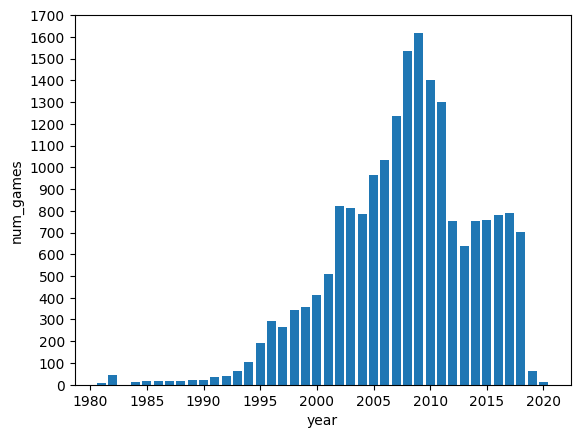

In [25]:
# Update the query to add a count of games released in each year called num_games

query='''
SELECT
    year,
    ROUND(AVG(critic_score), 2) AS avg_critic_score,
    COUNT(game) AS num_games
FROM reviews
NATURAL JOIN game_sales
GROUP BY year
    HAVING AVG(critic_score) IS NOT NULL
ORDER BY avg_critic_score DESC;
'''


# Let's plot the result of that query. 
# x is the year, y is the num_games

df_query = pd.read_sql(query,con=e)
_= plt.xlabel('year')
_= plt.ylabel('num_games')
_= plt.bar(df_query['year'], df_query['num_games'])
_= plt.yticks(np.arange(0,1800,100))
plt.show()


Based on the plot, it looks like there were a lot less games reviewed from 1981 to 1994.<br>
Let's focus on years with at least 100 reviewed games.

In [26]:
# Let's update the query so that it only returns years that have more than 100 reviewed games

query='''

    SELECT
        year,
        ROUND(AVG(critic_score), 2) AS avg_critic_score,
        COUNT(game) AS num_games
    FROM reviews
    NATURAL JOIN game_sales
    GROUP BY year
        HAVING COUNT(game) > 100 AND AVG(critic_score) IS NOT NULL
    ORDER BY avg_critic_score DESC

'''

display(pd.read_sql(query, con=e))

,year,avg_critic_score,num_games
0,1994,8.67,104
1,2014,7.58,755
2,2013,7.56,639
3,2012,7.50,755
4,2015,7.47,759
5,2017,7.43,789
6,2016,7.43,780
7,2018,7.39,703
8,2003,7.34,813
9,1999,7.28,359


## 5. Years that dropped off the critics' favorites list
<p>Now which years dropped off the list due to having a hundred or fewer reviewed games?<br>Let's create the two following tables based on the previous two queries:</p>
<h3 id="top_critic_years"><code>top_critic_years</code></h3>
<table>
<thead>
<tr>
<th style="text-align:left;">column</th>
<th>type</th>
<th>meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;"><code>year</code></td>
<td>int</td>
<td>Year of video game release</td>
</tr>
<tr>
<td style="text-align:left;"><code>avg_critic_score</code></td>
<td>float</td>
<td>Average of all critic scores for games released in that year</td>
</tr>
</tbody>
</table>
<h3 id="top_critic_years_more_than_hundred_games"><code>top_critic_years_more_than_hundred_games</code></h3>
<table>
<thead>
<tr>
<th style="text-align:left;">column</th>
<th>type</th>
<th>meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;"><code>year</code></td>
<td>int</td>
<td>Year of video game release</td>
</tr>
<tr>
<td style="text-align:left;"><code>num_games</code></td>
<td>int</td>
<td>Count of the number of video games released in that year</td>
</tr>
<tr>
<td style="text-align:left;"><code>avg_critic_score</code></td>
<td>float</td>
<td>Average of all critic scores for games released in that year</td>
</tr>
</tbody>
</table>

In [27]:
# Create the two csv to upload to the database

query_top_critic='''
SELECT
    year,
    ROUND(AVG(critic_score), 2) AS avg_critic_score
FROM reviews
NATURAL JOIN game_sales
GROUP BY year
    HAVING AVG(critic_score) IS NOT NULL
ORDER BY avg_critic_score DESC
LIMIT 10;
'''

query_top_critic_more_than_hundred='''
SELECT
    year,
    ROUND(AVG(critic_score), 2) AS avg_critic_score,
    COUNT(game) AS num_games
FROM reviews
NATURAL JOIN game_sales
GROUP BY year
    HAVING COUNT(game) > 100 AND AVG(critic_score) IS NOT NULL
ORDER BY avg_critic_score DESC
LIMIT 10;
'''

df_top_critic = pd.read_sql(query_top_critic, con=e)
df_top_critic.to_csv('dataset/top_critic_years.csv', index=False)

df_top_critic_more_than_hundred = pd.read_sql(query_top_critic_more_than_hundred, con=e)
df_top_critic_more_than_hundred.to_csv('dataset/top_critic_years_more_than_hundred_games.csv', index=False)


In [28]:
# Now that the new tables have been created and uploaded:
# Select the year and avg_critic_score for those years that dropped off the list of critic favorites.
# Order the results from highest to lowest avg_critic_score

query='''
SELECT
    year,
    avg_critic_score
FROM top_critic_years
WHERE year NOT IN (
                    SELECT 
                        year 
                    FROM top_critic_years_more_than_hundred_games
                )
ORDER BY avg_critic_score DESC;
'''

display(pd.read_sql(query, con=e))

,year,avg_critic_score
0,1984,10
1,1991,9
2,1990,9
3,1982,9
4,1992,9
5,1993,8
6,2019,8
7,1981,8
8,2020,8


## 6. Years video game players loved
<p>We need to gather more games and reviews data to do further analysis.<br>Let's move on to looking at the opinions of another important group of people: players!<br>To begin, let's create a query very similar to the one we used in Task Four, except this one will look at <code>user_score</code> averages by year rather than <code>critic_score</code> averages.</p>

In [29]:
# Select year, an average of user_score, and a count of games released in a given year, aliased and rounded.
# Include only years with more than a hundred reviewed games; group data by year.
# Order data by avg_user_score, and limit to ten results.

query='''
SELECT
    year,
    ROUND(AVG(user_score), 2) AS avg_user_score,
    COUNT(game) AS num_games
FROM reviews
JOIN game_sales
    USING(game)
GROUP BY year
    HAVING COUNT(game) > 100 AND AVG(user_score) IS NOT NULL
ORDER BY avg_user_score DESC
LIMIT 10;
'''

display(pd.read_sql(query, con=e))

,year,avg_user_score,num_games
0,1997,9.50,333
1,1999,9.20,478
2,1994,9.00,131
3,1998,9.00,423
4,2003,8.94,1695
5,2000,8.80,545
6,2007,8.75,2779
7,1996,8.60,351
8,2008,8.36,3270
9,2002,8.29,1645


## 7. Years that both players and critics loved
<p>Are there any years that showed up in both the user_score query and the critic_score query ? If so, those years would certainly be excellent ones!<br>Let's store the previous query in a new table:</p>
<h3 id="top_user_years_more_than_hundred_games"><code>top_user_years_more_than_hundred_games</code></h3>
<table>
<thead>
<tr>
<th style="text-align:left;">column</th>
<th>type</th>
<th>meaning</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;"><code>year</code></td>
<td>int</td>
<td>Year of video game release</td>
</tr>
<tr>
<td style="text-align:left;"><code>num_games</code></td>
<td>int</td>
<td>Count of the number of video games released in that year</td>
</tr>
<tr>
<td style="text-align:left;"><code>avg_user_score</code></td>
<td>float</td>
<td>Average of all user scores for games released in that year</td>
</tr>
</tbody>
</table>

In [30]:
# Create the csv to upload to the database

query_user_score_more_than_hundred='''
SELECT
    year,
    ROUND(AVG(user_score), 2) AS avg_user_score,
    COUNT(game) AS num_games
FROM reviews
JOIN game_sales
    USING(game)
GROUP BY year
    HAVING COUNT(game) > 100 AND AVG(user_score) IS NOT NULL
ORDER BY avg_user_score DESC
LIMIT 10;
'''

df_top_user = pd.read_sql(query_user_score_more_than_hundred, con=e)
df_top_user.to_csv('dataset/top_user_years_more_than_hundred_games.csv', index=False)


In [31]:
# Select the year results that appear on both tables' top 10.

query='''
SELECT
    year
FROM top_critic_years_more_than_hundred_games
WHERE year IN (
                SELECT 
                    year 
                FROM top_user_years_more_than_hundred_games
            );
'''

display(pd.read_sql(query, con=e))

,year
0,1994
1,1999
2,2003


## 8. Sales in the best video game years
<p>Looks like we've got three years that both users and critics agreed were in the top ten! There are many other ways of measuring what the best years for video games are, but let's stick with these years for now. We know that critics and players liked these years, but what about video game makers? Were sales good? Let's find out.</p>


In [32]:
# Select year and sum of games_sold, aliased as total_games_sold; order results by total_games_sold descending
# Filter game_sales based on whether each year is in the list returned in the previous task

query='''
SELECT
    year,
    SUM(games_sold) AS total_copies_sold_in_millions
FROM game_sales
WHERE year IN (
                SELECT 
                    year 
                FROM top_critic_years_more_than_hundred_games
                WHERE year IN (
                    SELECT year 
                    FROM top_user_years_more_than_hundred_games
                )
            )
GROUP BY year;
'''

display(pd.read_sql(query, con=e))

,year,total_copies_sold_in_millions
0,2003,330
1,1999,237
2,1994,52
